# Proxy Discrimination and `DiscriminationMitigator`

In [1]:
import json
import pandas as pd
import numpy as np
from DiscriminationMitigation import DiscriminationMitigator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
np.random.seed(1776)

## What is proxy descrimination?

In the context of protected class attributes, proxy discrimination is a statistical artifact that occurs in data when:

- Covariates are not independent of protected class membership
- The target is not independent of the group conditional on the covariates

This results in a case where covariates are able to proxy for protected class membership, and excluding the class variable from a model is insufficient to prevent the model from indirectly forming predictions on the basis of class membership.

In this notebook, we illustrate this problem of proxy discrimination as well as how `DiscriminationMitigator` addresses this statistical phenomenon.

### A data generating process that illustrates the problem

The following function defines a data generating process (DGP) that produces proxy discrimination as outlined above. We have a target variable, *y*, that we are trying to predict, dummies for class membership in one of two mutually exclusive groups, *g1* and *g0*, and we have a single covariate *w*. Group (i.e. protected class) membership is drawn from a binomial distribution. The draws of the covariate depend upon group membership (as well as independent normal draws), which generates a correlation between group and the covariate, *w*. 

The target variable *y* is determined by group membership, single covariate, and independent normal draws.  The "direct effect" of group membership on y can be thought of as possibly representing unobserved causal variables that are correlated with group, holding the covariate constant. Alternatively, it could also represent bias in the target or taste-based discrimination in the target.  It is this "direct effect" that allows dependency between the target and group membership, even after conditioning on the covariates. 

Note that the data generating process `dgp(.)` allows for the effect of the covariate to differ across groups. Such differences can be problematic for `DiscriminationMitigator`.  However, we do not, at present, explore these problems in this notebook. 

In [2]:
def dgp(N=4000, class_prob=0.5, 
        gamma=np.matrix([[2,3],[.4,.6]]), 
        alpha=np.matrix([[0,2]]), 
        beta=np.matrix([[2,2],[1,1]])):

    # Group membership indicators (in this cas mutually exclusive)
    g1 = np.random.binomial(1, p=class_prob, size=N)
    g0 = 1-g1 # group 0

    # Non-class covariate
    w = gamma[0,0]*g0 + gamma[0,1]*g1 + np.random.normal(0, 0.5, size=N) # linear function of group & shock
                                            
    # Target variable
    y = alpha[0,0]*g0   + alpha[0,1]*g1 + \
        beta[0,0]*g0*w + beta[0,1]*g1*w + \
        np.random.normal(0, 0.3, size=N)

    return pd.DataFrame([y, g0, g1, w]).T.rename(columns={0:'y', 1: 'g0', 2: 'g1', 3: 'w'})

In [3]:
N = 4000
data= dgp(4000)
print(data.head())
print("\n", data.shape)

          y   g0   g1         w
0  4.354907  1.0  0.0  2.088631
1  9.027452  0.0  1.0  3.543430
2  4.508174  1.0  0.0  2.222995
3  7.498461  0.0  1.0  2.609492
4  3.248735  1.0  0.0  1.649308

 (4000, 4)


### Visualizing between group and within group variation

Fundamentally, if cross-group differences in the distribution of the target variable remain after accounting for observables, then there exists a risk that a model predicting the target will discriminate on the basis of group membership -- whether or not group variables are included in the the model. 

The following series of figures illustrate statistical discrimination against groups and how it can occur even when class variables are omitted from the model.


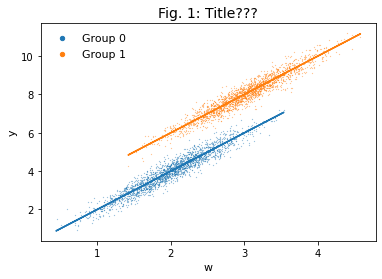

In [4]:
g0_grp = data.loc[data["g0"] == 1]
g1_grp = data.loc[data["g1"] == 1]

# Estimate fitted values from a linear regression model
g0_pred = LinearRegression().fit(g0_grp[["w"]], g0_grp["y"]).predict(g0_grp[["w"]])
g1_pred = LinearRegression().fit(g1_grp[["w"]], g1_grp["y"]).predict(g1_grp[["w"]])

# Scatter & line plot using Matplotlib
plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)
plt.plot(g0_grp["w"], g0_pred)
plt.plot(g1_grp["w"], g1_pred)
plt.title('Fig. 1: Title???', fontsize=14)
plt.xlabel('w', fontsize=11)
plt.ylabel('y', fontsize=11)
plt.legend(markerscale=25, frameon=False, fontsize=11)
plt.show()

Both within group and between group variation can drive associations. 

The scatterplot in figure 1 distinguishes between two groups, whose data are distributed differently.  Within both groups, there is a positive releationship between the target variable and the covariate `w0`. `Group 0` has lower values of `w0`, so one would expect it to have lower values of the target.  In fact, it has *much* lower values of the target, which cannot be entirely explained by lower values in the covariate.  

Running seperate regressions for each group (or including separate intercepts in a single regression) yields the parallel regression lines with different intercepts.  The line for `Group 0` is shifted down by the difference in intercepts.  

**This difference in intercepts represents predictive information in group membership**.  Even after accounting for all other covariates, there exists differences in the target between groups. That is, group membership contains additional information, which can be used to improve the prediction.  Exploiting this information in some decision rule would constitute statistical discrimination. 

It may be obvious that statistical discrimination occurs when this information is exploited directly by explictly using group membership when making predictions.  But statistical discrimination can also occur when this information is exploited indirectly, where group membership is implicit in the values of covariates.

For this discussion, we will consider two predictive models: 

the **comprehensive model**:  `f(w,g1)`

and 

the **group-excluded model**:  `f(w)`.  


### Group membership can predict outcomes even when group is excluded from predictive model 

Because group membership is implicit in the values of covariates, removing group membership from a predictive model is not sufficient to prevent the model from predicating its predictions upon group membership.  That is, decisions based on the fitted group-excluded model can still statistically discriminate.    

Based on standard intuition concerning residual regression and omitted variable bias in linear regression, the predictive content of any variable can be decomposed into a component mediated through predictions of the omitted variables and a direct, unmediated component.  If group variables are omitted from a model, then coefficient estimates on other models will incorporate indirect effects through the group variables.  Consequently, a portion of any forecast will be driven by forecasts of the omitted group variables. 

This intuition also applies to non-linear models, including machine learning models like neural nets or gradient boosted trees. 
To illustrate this point, we fit a neural net for predicting `y` using the group-excluded model `f(w)`, the fitted values of which yield the black upward-sloping s-shaped curve in Figure 2. 

In [5]:
# Function to create a Tensorflow Keras deep learning model
def keras_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# Function to aggregate a dataframe according to a rounded feature, 'w'
def aggregate_data(df):
    df = pd.concat([df, data[['w']].reset_index(drop=True)], axis=1)
    df['w'] = round(df['w'], 1)
    df = df.sort_values(by=['w'])
    return df.groupby(['w']).mean()

In [7]:
# Scatter & line plot using Matplotlib
# Train a Tensorflow Keras deep learning model
model = keras_model()
model.fit(data[['w']], data['y'], epochs=60, batch_size=128, verbose=0)
pred = model.predict(data[['w']]) # Generate prediction from model

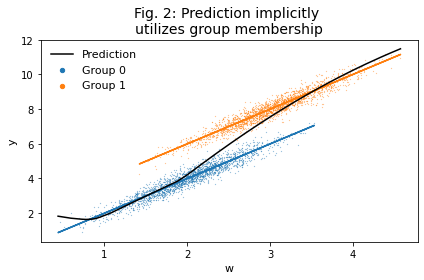

In [8]:
g0_grp = data.loc[data["g0"] == 1]
g1_grp = data.loc[data["g1"] == 1]

plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)
plt.plot(g0_grp["w"], g0_pred)
plt.plot(g1_grp["w"], g1_pred)

plt.plot(data.sort_values(by="w")[['w']], model.predict(data.sort_values(by="w")[['w']]), 
         label='Prediction', color="black")
plt.title('Fig. 2: Prediction implicitly \n'
          'utilizes group membership', fontsize=14)
plt.xlabel('w', fontsize=11)
plt.ylabel('y', fontsize=11)
plt.legend(markerscale=25, frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

For low values of `w`, the black curve overlays the regression line for group 0, matching the within-group association between changes in `y` and changes in `w`. But for intermediate values of `w`, the prediction slopes up more steeply, moving from the group 0 regression line and towards the group 1 regression line, after which it flattens out again to match the group 1 regression line.  

This black prediction line can be conceptualized as a weighted-average of within-group predictions, where the weights depend upon `w`.  That is, for values of `w` between 0 and 2, the person is most likely from group zero.  But as `w` moves from 2 to 3, probable membership rapidly shifts to group 1, and the weight on the group 1 regression line increases at the expense of the weight on the group 0 regression line. That is, part of the prediction from `w` comes from the within-group assocation between `w` and `y`,  and part of it comes the between-group difference in means times predicted group membership. 




### A model that excludes group will yield similar target predictions as a model that includes group for training but uses probability of group membership for predicting

In [9]:
# predict probability person is in group 1 given w0
g1_prob_model = keras_model()
g1_prob_model.fit(data['w'], data[['g1']], epochs=60, batch_size=128, verbose=0)
g1_prob_fit = g1_prob_model.predict(data[['w']]) 

# fit model of y given group membership and 
comprehensive_model = keras_model()
comprehensive_model.fit(data[['g1', 'w']], data['y'], epochs=60, batch_size=128, verbose=0)

# predict y, but only after replacing class with predicted class membership.  
data_with_predicted_g1 = data.copy()
data_with_predicted_g1[['g1']] = g1_prob_fit
data_with_predicted_g1 = data_with_predicted_g1.sort_values(by='w')
pred_using_predicted_g1 = comprehensive_model.predict(data_with_predicted_g1[['g1', 'w']]) 

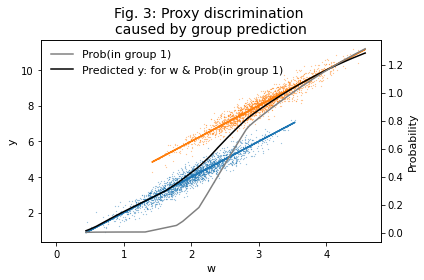

In [10]:
fig, ax1 = plt.subplots()
plt.title('Fig. 3: Proxy discrimination \n'
          'caused by group prediction', fontsize=14)
plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)
plt.plot(g0_grp["w"], g0_pred)
plt.plot(g1_grp["w"], g1_pred)

ax1.plot(data_with_predicted_g1[['w']], 
         pred_using_predicted_g1, 
         label='Prediction using predicted class', color="black")
plt.ylabel('y', fontsize=11)
plt.xlabel('w', fontsize=11)

ax2 = ax1.twinx() 
ax2.plot(data_with_predicted_g1[['w']], data_with_predicted_g1[['g1']], 
         color="grey", label = "Prob(in group 1)")
ax2.plot(np.array([0]), np.array([0]), 
         color="black", label = "Predicted y: for w & Prob(in group 1)")

plt.ylabel('Probability', fontsize=11)
plt.legend(markerscale=25, frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

Figure 3 clarifies prior intuition, showing how a component of `w` predicts they target by predicting group membership membership.

To produce figure 3, we:
1. **Fit the comprehensive model, which uses both group membership `g1` and the covariate `w` as predictors**.
2. **Fit probabilities of group membership `g1` as a function of `w`** (plotted as the grey line). The probabilities of group membership are estimated using a neural net (indeed, using one with the exact same structure as that used to predict the target).  By happenstance the probabilities do not fall between 0 and 1.  However, these details are immaterial.
3. **Predict the target `y`** (plotted as the black line) **using the model from step 1, but only after replacing person group membership with fitted probability of group membership.**

Note that the black line, which predicts the target in part by explitly using predicted group membership, is substantively identical to the black line from figure 2, which predicted the target using a model that excluded group membership.  It is in this sense that we say a component of the covariates proxies for group membership; excluding group membership from the model is not sufficient to prevent the model from statistically discriminating.  





### Predictions using constant counterfactual group membership do not admit proxy discrimination

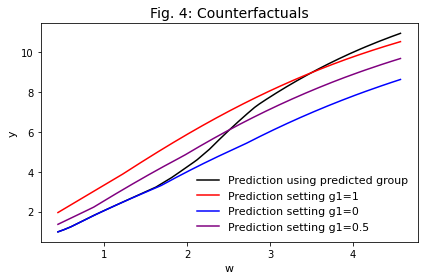

In [11]:
pred_using_predicted_g1 = comprehensive_model.predict(data_with_predicted_g1[['g1', 'w']]) # Generate prediction from model
data_counterfactual_g1 = data_with_predicted_g1.copy()
data_counterfactual_g1[['g1']] = 1
pred_using_g1_as_1 = comprehensive_model.predict(data_counterfactual_g1[['g1', 'w']])
data_counterfactual_g1[['g1']] = 0
pred_using_g1_as_0 = comprehensive_model.predict(data_counterfactual_g1[['g1', 'w']])
data_counterfactual_g1[['g1']] = 0.5
pred_using_g1_as_half = comprehensive_model.predict(data_counterfactual_g1[['g1', 'w']])


plt.title('Fig. 4: Counterfactuals', fontsize=14)
plt.plot(data_with_predicted_g1[['w']], 
         pred_using_predicted_g1, 
         label='Prediction using predicted group', color="black")
plt.plot(data_with_predicted_g1[['w']], 
         pred_using_g1_as_1 , 
         label='Prediction setting g1=1', color="red")
plt.plot(data_with_predicted_g1[['w']], 
         pred_using_g1_as_0 , 
         label='Prediction setting g1=0', color="blue")
plt.plot(data_with_predicted_g1[['w']], 
         pred_using_g1_as_half , 
         label='Prediction setting g1=0.5', color="purple")

plt.ylabel('y', fontsize=11)
plt.xlabel('w', fontsize=11)
plt.tight_layout()
plt.legend(markerscale=25, frameon=False, fontsize=11)
plt.show()

In Figure 4, we use the fitted model from the prior section, but we form predictions under four different group membership counterfactuals:
1. As before, the black line uses probability of group membership (as a function of `w`) in place of actual group membership. 
2. The red line treats all persons as though they were members of group 1 -- and for this reason tracks the regression line for group 1. 
3. Likewise, the blue line treats all persons as though they were members of group 0.  
4. Meanwhile, the purple line treats all persons as though there were in group 1 with 1/2 probability.  

Counterfactual forecasts 2 through 4 do not statistically discrminate on the basis of group membership -- explicitly or implicitly through proxy. Because the counterfactual predictions are based on the comprehensive model, the predictive content of covariates comes from their direct effects -- and not their predictiveness of group membership. Thus, the counterfactual predictions do not discriminate by proxy. Note, however, that mitigated predictions differ across groups.  Average predictions are higher for group 1 in all cases, but the difference in means is lower for the group counterfactual predictions. A discrimination mitigated prediction does not ensure equal predictions, but it does ensure that the the predictions are not made on the basis of group membership -- either directly or indirectly.  

#### Quantifying proxy discrimination 

Meanwhile, proxy statistical discrimination in the group-excluded model can be quantified by comparing its predictions with those of the counterfactual comprehensive model. For example, an observation from group 0 and with `w=1` would be predicted to have about `y=2` under both the group-excluded model and the comprehensive model with group membership at 0. But setting counterfactual group membership to 1 yields a prediction of about `y=4`.  Setting the counterfactual group membership to 0.5 -- the population share of group 1 -- yields a prediction of `y=1`, indicating that proxy discrimination in the group-excluded model accounts for an approximate 1 unit decrement from a flat prior on group membership at this level of `w`.  Similarly, proxy discrimination accounts for an approximate 2 unit increment in the forecasts at high levels of `w`.  When `w` approximately equals 2.5 the group-excluded model does not statistically discriminate. 

#### To predict using average counterfactual values, or to average predictions across counterfactual values?

Although counterfactual prediction 4 used a value of 0.5 in this pedagogical example, in general we advise against non-integer counterfactuals for interger variables.  This is because non-integer values are outside the domain of the data, and loss caused by non-linearities at non-integer points are not penalized. 

Instead of forming predicitions on a weighted average of counterfactuals...

   `pred = f(c1 = weight1 * 1 + weight0 * 0, w0 = w0_i)` 

...we recommend taking a weighted average of predictions under different counterfactuals

   `pred = weight1 * f(c1 = 1, w0=w0_i) + weight0 * f(c1 = 1, w0=w0_i)`

which ensures that the comprehensive model's arguments are within its domain.  

It is this approach that we implement in our discrimination mitigator.  Conceptually, the mitigator is a 'functional' (or 'closure'): 

1. The mitigator accepts a fitted model -- a function with covariates and group variables as arguments .
2. The mitigator returns a fitted model as a function of only the covariates.  This mitigated model requries additional parameters -- the weights used for averaging counterfactual forecasts.   

The choice of weights is largely arbitrary (reasonable choices might include uniform weights or population share), but, depending on the process being modeled, might have large effects on the forecast, including the relative ranking of groups. Users should check the mitigated forecast for sensitivity to weights. 

Both a model trained on only covariates and the mitigated model accept only covariates as arguments.  But because the pre-mitigated model included group membership durring training, the mitigated model does not proxy discriminate.

Below we provide detail guidance on utilizing the discrimination mitigator. 


# Using `DiscriminationMitigator`

To use DiscriminationMitigator, users will need to specify two objects. First, a configuration JSON file (see example below). Second, a pre-trained LightGBM or Tensorflow Keras machine learning model.

### Basic setup

#### Specify a configuration file

In [12]:
with open('example_config.json') as j:
    config = json.load(j)
print("Example configuration dictionary: \n", config)

Example configuration dictionary: 
 {'protected_class_features': ['g0', 'g1'], 'weights': {'g0': [1.0, 0.0]}, 'target_feature': ['y']}


The config file requires users specify the protected class feature(s) as a list. Any features estimated in the model but not included in this list are assumed to be non-protected classe features.

#### Take a pre-trained LightGBM or Tensorflow Keras model (sequential/model)
*NOTE: PROTECTED CLASS FEATURE(S) MUST BE INCLUDED IN THE TRAINING MODEL!*

In [13]:
# Note - we estimate the same model as directly above for clarity
comprehensive_model = keras_model()
comprehensive_model.fit(data[['g0', 'g1', 'w']], data['y'], epochs=60, batch_size=128, verbose=0)

#### Instantiate `DiscriminationMitigator` class & call `predictions()` method

In [14]:
mitigated = DiscriminationMitigator(df=data[['g0', 'g1', 'w']], model=comprehensive_model, 
                              config=config).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

   unadj_pred  unif_wts
0    4.208022  5.218817
1    9.022868  7.957291
2    4.476329  5.511364
3    7.258747  6.308582
4    3.287385  4.209965

         unadj_pred     unif_wts
count  4000.000000  4000.000000
mean      5.921209     5.945999
std       2.220754     1.422170
min       0.702223     1.092636
25%       4.014863     4.954698
50%       5.637917     6.052506
75%       8.022252     7.066934
max      10.219521     9.205349


The default specification returns a Pandas DataFrame with two features: `unadj_pred`, which is the unadjusted prediction, and `unif_wts`, which is the average of counterfactual predictions (i.e. uniform weights). This first column is equivalent to the prediction in Fig. 3 above.

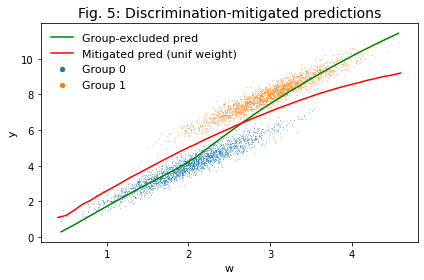

In [15]:
g0_grp = data.loc[data["g0"] == 1]
g1_grp = data.loc[data["g1"] == 1]

avg = aggregate_data(mitigated) # Average by rounded 'w'
plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)

group_excluded_model = keras_model()
group_excluded_model.fit(data[['w']], data['y'], epochs=60, batch_size=128, verbose=0)
group_excluded_pred = group_excluded_model.predict(data.sort_values(by='w')[['w']])
plt.plot(data.sort_values(by='w')[['w']], group_excluded_pred, label='Group-excluded pred', color='green')
plt.plot(avg['unif_wts'], label='Mitigated pred (unif weight)', color='red')
plt.title('Fig. 5: Discrimination-mitigated predictions', fontsize=14)
plt.xlabel('w', fontsize=11)
plt.ylabel('y', fontsize=11)
plt.legend(markerscale=25, frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

### Option 1: Reweight predictions using the joint distributions of another dataset

In [16]:
# Split the data into train/val and test sets
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, ['g0', 'g1', 'w']],
                                                    data['y'], random_state=1776,
                                                    test_size=0.2)
# Train / val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, 
                                                  test_size=0.2)

for x in X_train, X_val, X_test:
    print(x.shape)

(2560, 3)
(640, 3)
(800, 3)


In [17]:
# Reestimate the model
model = keras_model()
model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_val, y_val), verbose=0)

In [18]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train).predictions()

print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts
2518    9.156423  8.201531  8.157213
3164    1.998876  2.832083  2.796859
2693    3.395347  4.353728  4.310812
2107    8.849258  7.873985  7.828502
1249    4.053454  5.053819  5.008434

        unadj_pred    unif_wts     pop_wts
count  800.000000  800.000000  800.000000
mean     5.980628    6.010057    5.964235
std      2.206402    1.426176    1.424174
min      1.457570    1.941659    1.920923
25%      4.109478    5.038936    4.993601
50%      5.809565    6.047591    5.999111
75%      8.066310    7.133932    7.085929
max     10.236321    9.359711    9.319717


Optionally, `DiscriminationMitigator` allows users to reweight predictions to reflect the joint distributions of the protected class feature(s) in another dataset. This may be advantageous, for example, if your test set is considerably smaller than your training set. In this case, `unif_wts` reflects the joint distributions of `df` (i.e. uniform weights; the default), while `pop_wts` reflects the joint distributions of `train`.

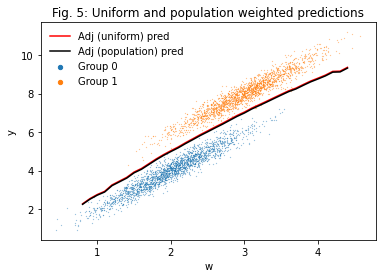

In [19]:
g0_grp = data.loc[data["g0"] == 1]
g1_grp = data.loc[data["g1"] == 1]

avg = aggregate_data(mitigated) # Average by rounded 'w'
plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.title('Fig. 5: Uniform and population weighted predictions')
plt.xlabel('w')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()

### Option 2: Custom reweighting of select feature marginal distributions

In [20]:
with open('example_weights.json') as j:
    weights = json.load(j)
print(weights)

{'g0': {'1': 1.0, '0': 0.0}, 'g1': {'1': 0.0, '0': 1.0}}


By default, DiscriminationMitigator uses uniform weights.  However, DiscriminationMitigator admits custom weights as arguments.

Custom weights are specified by providing a dictionary of custom marginal distributions to `weights`. Importantly, feature marginals must sum to 1.0, otherwise this will produce a ValueError. At present only marginal distributions of select featrures can be reweighted -- not joint distributions. 

Users may prefer to use custom weights for several reasons.  Among these, a user might be concerned that the choice of weights is driving predictions, as might occour if within-group correlations sharply differ across groups.  In this case, choice of weights might affect the ranking of group-mean forecasts, which a user could investigate.  

Altneratively, a user might choose to investigate how group membership colors interpretation of other variables.  For example, what would the model forecast for men if they had the covariates of women?  Subset the data to women and set the weights to 1 on the male group.  What would the model forecast for women if they had the covariates of men?  The relationship is not necessarily symmetric, but the mode of investigation is.  

In [21]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train, weights=weights).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts  cust_wts
2518    9.156423  8.201531  8.157213  7.264693
3164    1.998876  2.832083  2.796859  1.998876
2693    3.395347  4.353728  4.310812  3.395347
2107    8.849258  7.873985  7.828502  6.908229
1249    4.053454  5.053819  5.008434  4.053454

        unadj_pred    unif_wts     pop_wts    cust_wts
count  800.000000  800.000000  800.000000  800.000000
mean     5.980628    6.010057    5.964235    5.005487
std      2.206402    1.426176    1.424174    1.404555
min      1.457570    1.941659    1.920923    1.457570
25%      4.109478    5.038936    4.993601    4.039710
50%      5.809565    6.047591    5.999111    4.977314
75%      8.066310    7.133932    7.085929    6.104320
max     10.236321    9.359711    9.319717    8.527805



Warning! The following features are extremely correlated and thus may be one-hot vectors: g0 g1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


In the presence of custom weights, `DiscriminationMitigator` raises a warning if any features appear extremely correlated, suggesting they may be mutually exclusive one-hot vectors and that custom weights should therefore reflect their complementarity in the underlying data. In our case, the joint distributions of protected class features `g0` and `g1` are polar opposites, meaning we need to reweight *both* of these features. `DiscriminationMitigator`, however, does not enforce that custom weights of adjacent one-hot vectors do in fact sum to 1. 

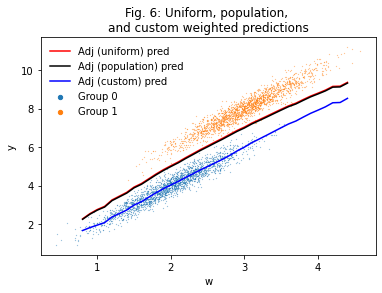

In [22]:
g0_grp = data.loc[data["g0"] == 1]
g1_grp = data.loc[data["g1"] == 1]


avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(g0_grp["w"], g0_grp["y"], label='Group 0', s=0.03)
plt.scatter(g1_grp["w"], g1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.plot(avg['cust_wts'], label='Adj (custom) pred', color='blue')
plt.title('Fig. 6: Uniform, population, \n'
          'and custom weighted predictions')
plt.xlabel('w')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()